In [1]:
import os
from dotenv import load_dotenv
load_dotenv(override=True)

True

LangGraph agent

In [2]:
# Agent tool: Search web for relevant pages, documents, etc. related to the query, and return the URLs of those pages
from langchain_community.tools import DuckDuckGoSearchResults
from langchain_core.tools import tool
from typing import Tuple, Any

@tool(response_format='content_and_artifact')
def search_urls(query: str, news_backend: bool = False) -> Tuple[str, Any]:
    """
    Retrieve URLs of relevant websites for the given search query, using DuckDuckGo.
    Set news_backend variable to True to retrieve URLs from news sites, in cases where the absolute most current information is required.
    Otherwise, set news_backend to False to retrieve only site URLs from .edu and .gov websites, for the most official information.
    """
    search = DuckDuckGoSearchResults(output_format='list', num_results=5, keys_to_include=['link'])
    results = search.invoke(query, backend='news') if news_backend else search.invoke(f'{query} site:(.gov | .edu)')
    results_serialized = '\n'.join([f'URL: {result['link']}' for result in results])
    
    return results_serialized, results

In [3]:
from langchain_chroma import Chroma
from langchain_community.document_loaders import WebBaseLoader
from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.tools import tool

@tool(response_format='content_and_artifact')
def retrieve_from_urls(query: str, web_paths: list[str]):
    """
    Retrieve content from a provided list of URLs that are related to a query. 
    """
    vector_store = Chroma(embedding_function=OpenAIEmbeddings())
    
    loader = WebBaseLoader(
        web_paths=web_paths,
    )
    docs = loader.load()
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
    all_splits = text_splitter.split_documents(docs)
    vector_store.add_documents(documents=all_splits)

    retrieved_docs = vector_store.similarity_search(query, k=5)
    serialized = '\n'.join([f'Source: {doc.metadata}\tContent: {doc.page_content}' for doc in retrieved_docs])
    
    return serialized, retrieved_docs

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [4]:
from langchain_openai import ChatOpenAI
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import create_react_agent
from langchain_core.messages import SystemMessage

llm = ChatOpenAI(temperature=0.1)
memory = MemorySaver()
prompt = '''
You are a helpful agent who specializes in assisting international college students living in the United States.
Please use the provided search and retrieval tools to answer the prompt as accurately as possible. 
Append keywords such as "for international students" to the search query to get results tailored to international students studying abroad.
Use a friendly tone when answering questions, as if you were a college guidance counselor.
'''
system_prompt = SystemMessage(prompt)

agent = create_react_agent(model=llm, prompt=system_prompt, tools=[search_urls, retrieve_from_urls], checkpointer=memory)

In [16]:
from langchain_core.messages import HumanMessage

messages = [HumanMessage(content="How can I make sure I'm eligible for an internship as a student from China?")]
config = {'configurable': {'thread_id': 'k'}}

In [76]:
response = agent.invoke({'messages': messages}, config)
print(response)

content='It seems that the retrieved information provides guidance on finding internships abroad and leveraging mentorship programs and networking opportunities. Here are some key points to consider as a third-year student from China starting an internship:\n\n1. **Mentorship Programs**: Look for mentorship programs at your university that can provide guidance on interning abroad. A mentor aligned with your career interests can offer valuable insights and connections to enhance your internship opportunities.\n\n2. **Networking Tips**: Connect with peers, upperclassmen, and alumni who have interned in your desired countries or cities. Alumni associations can be particularly beneficial as they understand the challenges of entering the job market and can provide valuable references.\n\n3. **External Internship Placement Programs**: Explore external internship placement programs, ensuring to choose reputable organizations. While some programs may offer visa assistance, be mindful of potent

In [ ]:
# Streaming
for step in agent.stream(
    {"messages": messages}, config,
    stream_mode="values"
):
    step["messages"][-1].pretty_print()

In [ ]:
from IPython.display import display, Image
display(Image(agent.get_graph().draw_mermaid_png()))

Adding context to return sources

In [5]:
from langgraph.graph import MessagesState
from langchain_core.documents import Document
from typing import List

class MessagesStateWithContext(MessagesState):
    context: List[Document]

@tool(response_format='content_and_artifact')
def search_and_retrieve_from_web(query: str, news_backend: bool = False) -> Tuple[str, Any]:
    """
    Retrieve most relevant content from websites given a query, using DuckDuckGo.
    Set news_backend variable to True to retrieve URLs from news sites, in cases where the absolute most current information is required.
    Otherwise, set news_backend to False to retrieve only site URLs from .edu and .gov websites, for the most official information.
    """
    search = DuckDuckGoSearchResults(output_format='list', num_results=5, keys_to_include=['link'])
    results = search.invoke(query, backend='news') if news_backend else search.invoke(f'{query} site:(.gov | .edu)')
    
    vector_store = Chroma(embedding_function=OpenAIEmbeddings())
    
    loader = WebBaseLoader(
        web_paths=[result['link'] for result in results],
    )
    docs = loader.load()
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
    all_splits = text_splitter.split_documents(docs)
    vector_store.add_documents(documents=all_splits)

    retrieved_docs = vector_store.similarity_search(query, k=5)
    serialized = '\n'.join([f'Source: {doc.metadata}\tContent: {doc.page_content}' for doc in retrieved_docs])
    
    return serialized, retrieved_docs

In [23]:
from langgraph.prebuilt import ToolNode

def tool_or_respond(state: MessagesStateWithContext):
    """
    Generate tool calls to search and retrieve from webpages, or respond to the prompt.
    """
    llm_with_tools = llm.bind_tools([search_and_retrieve_from_web])
    response = llm_with_tools.invoke(state['messages'])
    return {'messages': [response]}

tools = ToolNode([search_and_retrieve_from_web])

def generate(state: MessagesStateWithContext):
    """
    Generate an answer given retrieved content and prior message history.
    """
    # Get tool messages from previous node
    recent_tool_messages = []
    for message in reversed(state['messages']):
        if message.type == 'tool':
            recent_tool_messages.append(message)
        else:
            break
    tool_messages = recent_tool_messages[::-1]

    # Create message history + new system prompt specifically for RAG
    docs_content = '\n\n'.join([doc.content for doc in tool_messages])
    system_prompt = SystemMessage(f'''
    You are an assistant for question-answering tasks. 
    Use the following pieces of retrieved context to answer the question(s) as thoroughly and accurately as possible. 
    If you don't know the answer, just say that you don't know.
    Use a friendly tone when answering questions, as if you were a college guidance counselor.
    
    Context: {docs_content}
    ''')  # Prompt adapted from rlm/rag-prompt

    conversation_messages = [
        message for message in state['messages'] if 
            message.type in ('human', 'system')
            or 
            (message.type == 'ai' and not message.tool_calls)
    ]
    
    all_messages = [system_prompt] + conversation_messages

    # Get response and source documents
    response = llm.invoke(all_messages)
    context = []
    for tool_message in tool_messages:
        context += [tool_message.artifact]

    return {'messages': [response], 'context': context}

In [24]:
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import tools_condition

graph_builder = StateGraph(MessagesStateWithContext)

graph_builder.add_node(tool_or_respond)
graph_builder.add_node(tools)
graph_builder.add_node(generate)

graph_builder.set_entry_point('tool_or_respond')
graph_builder.add_conditional_edges(
    'tool_or_respond',
    tools_condition,
    {END: END, 'tools': 'tools'},
)
graph_builder.add_edge('tools', 'generate')
graph_builder.add_edge('generate', END)

graph = graph_builder.compile()

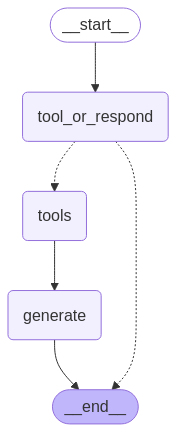

In [25]:
from IPython.display import display, Image
display(Image(graph.get_graph().draw_mermaid_png()))

In [37]:
user_prompt = "How can I make sure I'm eligible for an internship as a student from China?"
messages = [
    SystemMessage('''
    You are a helpful tool-calling agent who specializes in assisting international college students living in the United States.
    Please use the provided search and retrieval tools to answer the prompt as accurately as possible.
    Append keywords such as "for international students" to the search query to get results tailored to international students studying abroad.
    Unless specified in the prompt, assume that the user needs official information rather than the most current information.
    '''), 
    HumanMessage(content=user_prompt)
]
config = {'configurable': {'thread_id': 'vana'}}

In [43]:
for i in range(10):
    print('test')
    pass

test
test
test
test
test
test
test
test
test
test


In [38]:
steps = graph.stream(
    {"messages": messages}, config,
    stream_mode="values"
)
for step in steps:
    print(step["messages"][-1])

In [51]:
step['context'][0][0].metadata

{'description': 'Stanford Global Studies Internship Program supports CEAS and EALC graduate students for self-arranged summer internships in the U.S. or abroad. Applications\xa0may focus on any aspect of East Asian Studies - arts, business, people & society, history, culture, technology, and politics. The internship can be related to\xa0public service or academic/policy research.',
 'language': 'en',
 'source': 'https://sgs.stanford.edu/internships/2025-internship-grants-ceas-and-ealc-graduate-students',
 'title': '2025 Internship Grants for CEAS and EALC Graduate Students | Global Studies'}